In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ***Imports***

In [ ]:
from collections import Counter
import re
import string

# from nltk.stem import WordNetLemmatizer
# from nltk.stem import PorterStemmer

In [ ]:
!pip install transformers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from transformers import BertForQuestionAnswering, AutoTokenizer
from transformers import pipeline
# import nltk
# nltk.download('all')
# from nltk.corpus import stopwords
# nltk.download('stopwords')
# from nltk.tokenize import word_tokenize

In [ ]:
# stemmer = PorterStemmer()
# lemmatizer = WordNetLemmatizer()

# Loading model and datasets

Model: bert-base-cased-squad2

Datasets: Evaluation dataset, Available beds dataset

In [ ]:
modelname = 'deepset/bert-base-cased-squad2'
model = BertForQuestionAnswering.from_pretrained(modelname)
tokenizer = AutoTokenizer.from_pretrained(modelname)

nlp = pipeline('question-answering', model=model, tokenizer=tokenizer)

In [ ]:
eval_data = pd.read_csv('/content/drive/MyDrive/Capstone/datasets/evaluation_data.csv')
beds_test = pd.read_csv('/content/drive/MyDrive/Capstone/datasets/recent_beds_df')

# Preparing the datasets

In [ ]:
print(set(beds_test['area'].tolist()))

{nan, 'Thirupathur', 'Alirajpur', 'Narayanpet', 'Kancheepuram', 'Rajanna', 'Jagtial', 'Damoh', 'Anuppur', 'Singrauli', 'Rural/DHO', 'Chittoor', 'Neemuch', 'Vikarabad', 'Namakkal', 'Dindigul', 'Panna', 'Chennai', 'Sehore', 'Khandwa', 'Tiruppur', 'Adilabad', 'PCMC', 'Betul', 'Badradri', 'CS/Nagarpalika', 'Jangaon', 'Ramanathapuram', 'Salem', 'Chhatarpur', 'Jhabua', 'Sivagangai', 'Burhanpur', 'Madurai', 'Shivpuri', 'Guna', 'TheNilgiris', 'Umaria', 'Ariyalur', 'Y.s.r.', 'Khadki Cantonment Board', 'Tiruvannamalai', 'Kamareddy', 'Thoothukudi', 'Dehuroad Cantonment Board', 'Mayiladuthurai', 'Chengalpet', 'Dhar', 'Shajapur', 'Gwalior', 'Mahabubnagar', 'Ranipet', 'Nizamabad', 'Shahdol', 'Villupuram', 'Anantapur', 'Warangal Urban', 'Bhind', 'Mandla', 'Theni', 'Siddipet', 'Vidisha', 'Chhindwara', 'Sangareddy', 'Delhi', 'Harda', 'Morena', 'Hyderabad', 'Wanaparthy', 'Mancherial', 'Rewa', 'Hoshangabad', 'Jogulamba', 'Nirmal', 'Ujjain', 'Tikamgarh', 'Thanjavur', 'Bengaluru', 'Ashoknagar', 'Kanyakumar

In [ ]:
# Lowering text in area list
beds_test['area'] = beds_test['area'].str.lower()
area_list = list(set(beds_test['area'].tolist()))
area_list.remove(area_list[0]) ### removing first value (nan)

print(area_list)

['prakasam', 'karur', 'indore', 'panna', 'tiruvallur', 'ratlam', 'mahabubnagar', 'thenilgiris', 'ashoknagar', 'salem', 'y.s.r.', 'kanyakumari', 'ranipet', 'erode', 'mayiladuthurai', 'hoshangabad', 'yadadri', 'sivagangai', 'villupuram', 'kurnool', 'seoni', 'nalgonda', 'dindori', 'ramanathapuram', 'nirmal', 'pudukkottai', 'east godavari', 'chhatarpur', 'ujjain', 'vidisha', 'mulugu', 'barwani', 'virudhunagar', 'tikamgarh', 'badradri', 'rajanna', 'alirajpur', 'thirupathur', 'chittoor', 'damoh', 'morena', 'anantapur', 'suryapet', 'rural/dho', 'komaram bheem', 'khadki cantonment board', 'balaghat', 'bhind', 'dindigul', 'krishnagiri', 'burhanpur', 'tiruppur', 'thiruvarur', 'nizamabad', 'vizianagaram', 'jagtial', 'mancherial', 'krishna', 'thoothukudi', 'dewas', 'jabalpur', 'pcmc', 'mahabubabad', 'tirunelveli', 'pune cantonment', 'shivpuri', 'warangal urban', 'khammam', 'tiruvannamalai', 'srikakulam', 'nilgiris', 'thanjavur', 'siddipet', 'sheopur', 'nagarkurnool', 'jangaon', 'visakhapatanam', '

In [ ]:
# Splitting evaluation dataset

# Shuffling the dataset
eval_data = eval_data.sample(frac=1).reset_index(drop=True)
# Splitting the dataset into 4 parts
eval1, eval2, eval3, eval4 = np.array_split(eval_data, 4)
# Storing the tweets from evaluation datasets to lists
eval = eval_data['tweets'].tolist()
eval1 = eval1['tweets'].tolist()
eval2 = eval2['tweets'].tolist()
eval3 = eval3['tweets'].tolist()
eval4 = eval4['tweets'].tolist()

In [ ]:
# Sample of evaluation dataset 1
eval1

['#Urgent Name : Nooruddin Ahmad Age : around 65 Need : Bed for covid patient, oxygen levels critically low (63) Location : Prayagraj Please if there are an possibility of a bed, please send leads Contact: Hassan Ahmad - +917897210081 #COVID19India #Prayagraj',
 'Please HELP A Shobha Rani Age - 60 years Contact - Ajeet (9935847593) City : Delhi, Noida ICU bed needed with Oxygen on urgent basis. #Delhi #COVID19India #Oxygen #OxygenShortage #OxygenCylinder #Urgent #Emergency',
 'Anv leads for beds in noida? @htdelhi @SonuSood @FcSonuSood @CMODelhi #Beds #Noida #CovidResources #COVID19Help',
 '#allindia #COVID19India If you are aware about the availability of #bed #Remedisivir and #Oxygen PLEASE SHARE! We will update it in the India wide #CovidResources document. #urgent #share #spreadtheword',
 '#Delhi #Gurgaon #Dwarka #Hospital #Urgent #AMPLIFY #Assist Need #Hospital #Bed for my aunt. #AnyoneTHelp? Smt Santosh Bhan 73 Sat: 60-65 palam vihar gurgaon Contact: 9811146673 .@Suhelseth.@OmarA

# ***Model Inference***

In [ ]:
# Defining a function for model inference on evaluation sets
def modelInference(answers_list, evaluation_set):
  for tweet in evaluation_set:
    context = tweet

    sol = nlp({
        'question': 'what kind of bed is needed?',
        'context': context
    })
    answers_list.append(sol['answer'])
  return answers_list

# # Defining lists to store model inference results
answer1, answer2, answer3, answer4 = [], [], [], []

In [ ]:
# Inference on evaluation set 1.
answer1 = modelInference(answer1, eval1)
# Inference on evaluation set 2.
answer2 = modelInference(answer2, eval2)
# Inference on evaluation set 3.
answer3 = modelInference(answer3, eval3)
# Inference on evaluation set 4.
answer4 = modelInference(answer4, eval4)

In [ ]:
answer4

['ICU bed',
 'ICU',
 'oxygen',
 'grandmother',
 'Ventilator Bed',
 'ICUBed #VentilatorBed',
 'Ventilator Bed',
 'ICU Bed',
 'oxygen',
 'ventilator',
 'ICU bed',
 'Ventilator',
 'ventilator bed',
 'ICU bed',
 'ventilator',
 'Noida ICU',
 'ICU beds',
 'oxygen',
 'hospital bed with oxygen',
 'ventilator bed',
 'no beds',
 'ICU',
 'ICU Ventilator bed',
 'Oxygen',
 'Covid19IndiaHelp',
 'ventilater',
 'icu bed',
 'ventilator',
 'VentilatorBed #COVIDEmergencylndia',
 'Beds #CovidSOS #UttarPradesh',
 'oxygen',
 '83',
 'oxygen',
 'icu',
 'Bipap machine',
 'hospital bed',
 'ICUBedsospital bed',
 'invasive ventilator bed',
 'HDU/ICU bed',
 'ICU bed',
 'dialysis bed']

In [ ]:
# Defining a function for calculating accuracy.
def calculate_accuracy (results):
  total_len = len(results)
  count = 0
  for i in range (0, len(results)):
    if (results[i].lower().find('icu') > -1):
      count += 1
    elif (results[i].lower().find('venti') > -1):
      count += 1
    elif (results[i].lower().find('oxygen') > -1):
      count += 1
    elif (results[i].lower().find('bed') > -1):
      count += 1
    elif (results[i].lower().find('urgent') > -1):
      count += 1
    elif (results[i].lower().find('critical') > -1):
      count += 1
    else:
      pass
  accuracy = (count/total_len)*100
  # print(accuracy)
  return accuracy

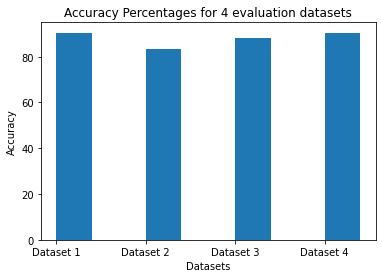

[90.47619047619048, 83.33333333333334, 88.09523809523809, 90.2439024390244]


In [ ]:
# Plotting the accuracies of evaluation datasets.
X = ['Dataset 1','Dataset 2','Dataset 3','Dataset 4']

accuracies = [calculate_accuracy(answer1),
         calculate_accuracy(answer2),
         calculate_accuracy(answer3),
         calculate_accuracy(answer4)]
  
X_axis = np.arange(len(X))
  

plt.bar(X_axis + 0.2, accuracies, 0.4, label = 'Boys')
  
plt.xticks(X_axis, X)
plt.xlabel("Datasets")
plt.ylabel("Accuracy")
plt.title("Accuracy Percentages for 4 evaluation datasets")
plt.show()
print(accuracies)

In [ ]:
# def process_text(result):
#   for tweet in result:
#     # Lowering text
#     tweet.lower()
#     # Deleting Mentions
#     tweet = re.sub("@[A-Za-z0-9_]+","", tweet)
#     # Removing Hashtag symbols from the text
#     tweet = tweet.replace('#', '')
#     # Punctuation removal
#     tweet = re.sub(r'[^\w\s]', '', tweet)
#     # Removing URLs
#     tweet = re.sub('((www.[^s]+)|(https?://[^s]+))',' ',tweet)
#     # Removing numbers
#     tweet = re.sub('[0-9]+', '', tweet)
#   return result

In [ ]:
hash_count_data = ' '.join(eval)

In [ ]:
# Finding most repeated hashtags for analysis
hash_counts = Counter(re.findall(r'#([a-z0-9]+)', ' '.join(eval), re.I))
print(dict(hash_counts))
myDict = {key:val for key, val in hash_counts.items() if val >= 20}
print(myDict)

{'Urgent': 57, 'COVID19India': 50, 'Prayagraj': 2, 'Delhi': 36, 'Oxygen': 14, 'OxygenShortage': 2, 'OxygenCylinder': 2, 'Emergency': 22, 'Beds': 17, 'Noida': 8, 'CovidResources': 17, 'COVID19Help': 4, 'allindia': 1, 'bed': 3, 'Remedisivir': 2, 'urgent': 17, 'share': 1, 'spreadtheword': 1, 'Gurgaon': 1, 'Dwarka': 1, 'Hospital': 4, 'AMPLIFY': 1, 'Assist': 1, 'Bed': 5, 'AnyoneTHelp': 1, 'vizag': 4, 'VizagCovidHelp': 18, 'COVIDEmergency': 30, 'Ventilator': 4, 'ICUBEDS': 2, 'SOS': 17, 'Hospitals': 1, 'Kakinada': 2, 'Covid': 6, 'Covid19IndiaHelp': 24, 'CovidSOS': 22, 'COVID19': 15, 'CovidHelp': 28, 'Bengaluru': 5, 'OxygenCylinders': 4, 'OxygenConcentrators': 2, 'Remdesivir': 2, 'SosBangalore': 2, 'Bangalore': 6, 'SaveBangalore': 2, 'HelpBangalore': 2, 'Covid19': 4, 'Corona': 2, 'varanasi': 2, 'vns': 1, 'oxygenbed': 1, 'ventilater': 1, 'COVIDSecondWavelnIndia': 2, 'CUBeds': 7, 'ICUBedNeeded': 1, 'help': 14, 'allahabad': 1, 'prayagraj': 1, 'shantipuram': 1, 'beds': 6, 'ICU': 11, 'COVIDEmergenc

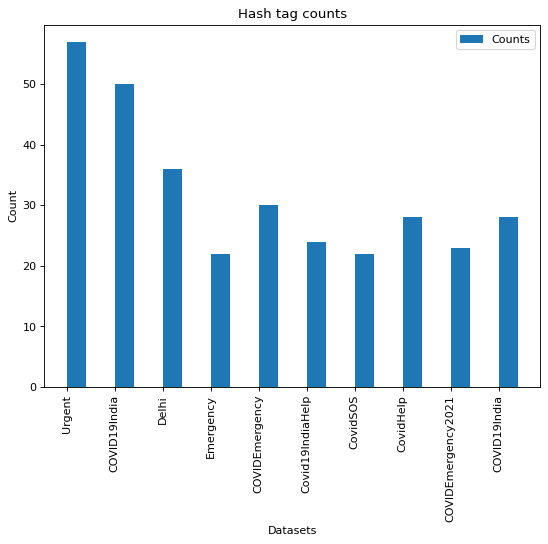

[57, 50, 36, 22, 30, 24, 22, 28, 23, 28]


In [ ]:
X = []
hash_counts_yaxis = []
for key, obj in myDict.items():
  # print(key, obj)
  X.append(key)
  hash_counts_yaxis.append(obj)

X_axis = np.arange(len(hash_counts_xaxis))
  
plt.figure(figsize =(8, 6), dpi=80)
plt.bar(X_axis + 0.2, hash_counts_yaxis, 0.4, label = 'Counts')
# plt.bar(X_axis - 0.2, final, 0.4, label = 'Final Accuracy')
plt.xticks(rotation=90)

plt.xticks(X_axis, X)
plt.xlabel("Datasets")
plt.ylabel("Count")
plt.title("Hash tag counts")
plt.legend()
plt.show()
print(hash_counts_yaxis)

# ***ANALYZE, SEARCH, AND REPLY***

In [ ]:
# Defining a function for searching beds in the dataframe by city name and bedtype. 
# Results are used to print a reply for the sake of commenting on tweets of people in need.

def searchAndReply (data, area, bedtype):
  # Filter dataframe by location
    new = data.loc[data['area'] == area]
    
    hname = ""
    haddress = ""
    count = 0
    hnames = new['hospital_name'].tolist()
    haddresses = new['hospital_address'].tolist()
    btype = ""

    o = new['available_beds_with_oxygen'].tolist()
    ic = new['available_icu_beds_without_ventilator'].tolist()
    v = new['available_icu_beds_with_ventilator'].tolist()

  # For ICU beds
    if (bedtype == 1):
        for i in range (0, len(ic)):
            if (ic[i] > 5):
                btype = " ICU "  
                count = ic[i]
                hname = hnames[i]
                haddress = haddresses[i]
                break
  # For Oxygen beds
    elif (bedtype == 2):
        for i in range (0, len(o)):
            if (o[i] > 5):
                btype = " Oxygen " 
                count = o[i]
                hname = hnames[i]
                haddress = haddresses[i]
                break
  # For Ventillator beds
    elif (bedtype == 3):
        for i in range (0, len(v)):
            if (v[i] > 5):
                btype = " Ventillator " 
                count = v[i]
                hname = hnames[i]
                haddress = haddresses[i]
                break
  # We recommend oxygen beds, for people who didn't mention bed type
    elif (bedtype == 4):
        for i in range (0, len(ic)):
            if (o[i] > 5):
                btype = " Oxygen " 
                count = o[i]
                hname = hnames[i]
                haddress = haddresses[i]
                break

    if(count == 0):
        result = "No beds available"
    else:
        result = str(int(count))+btype+"beds are available in: "+hname+', '+haddress
    return result



In [ ]:
searchAndReply(beds_test, "hyderabad", 2)

'50 Oxygen beds are available in: AH GOLKONDA, Maruthi Nagar, Langar Houz, Hyderabad, Telangana 500008, India'

## Removing tweets without city names, because we need the area name in order to recommend beds near the patient.

In [ ]:
# Extracting area list from the available beds dataframe

final_eval1, final_eval2, final_eval3, final_eval4 = [], [], [], []

# Selecting tweets with area names
def selectTweetsWithAreas (evals):
  final_eval = []
  for i in range(0, len(area_list)):
    for j in range (0, len(evals)):
      if ((evals[j].lower()).find(area_list[i]) > -1):
        # print(area_list[i]+' found in '+evals[j])
        final_eval.append(evals[j])
  return final_eval

final_eval1 = selectTweetsWithAreas(eval1)
final_eval2 = selectTweetsWithAreas(eval2)
final_eval3 = selectTweetsWithAreas(eval3)
final_eval4 = selectTweetsWithAreas(eval4)

In [ ]:
print("Tweet counts without and with city names")
print(len(eval1)+len(eval2)+len(eval3)+len(eval4))
print(len(final_eval1)+len(final_eval2)+len(final_eval3)+len(final_eval4))

Tweet counts without and with city names
167
86


In [ ]:
# Analyzing evaluation datasets with BERT to get the inputs
def analyzeWithBert (evals):
  answer = []
  for tweet in evals:
    context = tweet

    sol = nlp({
        'question': 'what kind of bed is needed?',
        'context': context
    })
    answer.append(sol['answer'])
  return answer

answer11, answer22, answer33, answer44 = [], [], [], []
  
answer11 = analyzeWithBert(final_eval1)
answer22 = analyzeWithBert(final_eval2)
answer33 = analyzeWithBert(final_eval3)
answer44 = analyzeWithBert(final_eval4)

In [ ]:
print(calculate_accuracy(answer11))
print(calculate_accuracy(answer22))
print(calculate_accuracy(answer33))
print(calculate_accuracy(answer44))

100.0
95.83333333333334
84.21052631578947
95.23809523809523


In [ ]:
answer22

['ICU Bed',
 'ICU bed',
 '#bed',
 'Urgently needed',
 'hospital bed',
 'Oxygen bed',
 'Oxygen',
 'ventilator bed',
 'Beds',
 'Emergency #UrgentHelp',
 'ICU',
 'ICU',
 'ICU Bed',
 'Covid oxygen support bed',
 'CovidSOS #delhi #DelhiNCR',
 'Oxygen / ICU',
 'OxygenBed',
 'Beds',
 'Beds',
 'hospital beds with oxygen',
 'oxygen bed',
 'ventilator bed',
 'ventilator bed',
 'ICU bed']

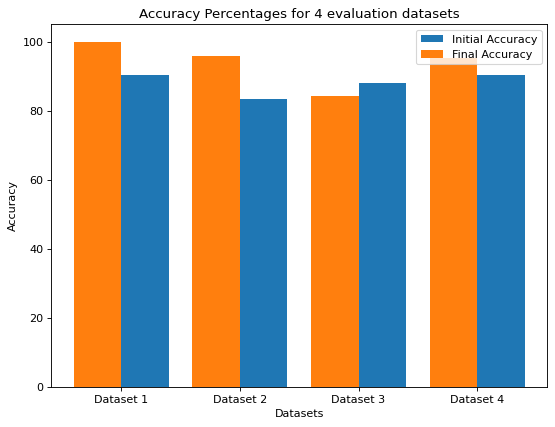

[90.47619047619048, 83.33333333333334, 88.09523809523809, 90.2439024390244]
[100.0, 95.83333333333334, 84.21052631578947, 95.23809523809523]


In [ ]:
X = ['Dataset 1','Dataset 2','Dataset 3','Dataset 4']


initial = [calculate_accuracy(answer1),
         calculate_accuracy(answer2),
         calculate_accuracy(answer3),
         calculate_accuracy(answer4)]

final = [calculate_accuracy(answer11),
         calculate_accuracy(answer22),
         calculate_accuracy(answer33),
         calculate_accuracy(answer44)]
  
X_axis = np.arange(len(X))
  
plt.figure(figsize =(8, 6), dpi=80)
plt.bar(X_axis + 0.2, initial, 0.4, label = 'Initial Accuracy')
plt.bar(X_axis - 0.2, final, 0.4, label = 'Final Accuracy')
  

plt.xticks(X_axis, X)
plt.xlabel("Datasets")
plt.ylabel("Accuracy")
plt.title("Accuracy Percentages for 4 evaluation datasets")
plt.legend()
plt.show()
print(initial)
print(final)